# Pseudo-Labeling + Supervised Learning

**Approach**: Semi-supervised learning with programmatic labeling

This advanced approach expands the training set:
1. Use best baseline (embedding) to predict on unannotated LinkedIn CVs
2. Filter for high-confidence predictions (confidence > 0.85)
3. Combine pseudo-labeled CVs with lookup tables
4. Train transformer on expanded dataset
5. Compare with baseline transformer (trained only on lookup tables)

**Hypothesis**: LinkedIn CV pseudo-labels help domain adaptation
- Lookup tables have clean, simple job titles
- LinkedIn CVs have more complex, real-world titles
- Training on both should improve generalization

**Training Data**: Lookup tables (gold) + Pseudo-labeled CVs (silver)  
**Validation Data**: Annotated LinkedIn CVs (final evaluation only)

In [1]:
import pandas as pd
import numpy as np
import json
import torch
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Import data loaders and models
import sys
sys.path.append('../')
from src.data.loader import load_label_lists, load_inference_dataset, load_evaluation_dataset
from src.models.embedding_classifier import create_domain_classifier, create_seniority_classifier
from src.models.transformer_classifier import TransformerClassifier

# Paths
DATA_DIR = Path('../data')
RESULTS_DIR = Path('./results')
MODELS_DIR = Path('../models')
RESULTS_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

%matplotlib inline

Using device: cuda


## 1. Load Data

In [2]:
# Load lookup tables (gold labels)
dept_df, sen_df = load_label_lists(DATA_DIR)

print(f"Gold-labeled data (lookup tables):")
print(f"  Department: {len(dept_df):,} examples")
print(f"  Seniority:  {len(sen_df):,} examples")

Gold-labeled data (lookup tables):
  Department: 10,145 examples
  Seniority:  9,428 examples


In [3]:
# Load unannotated CVs for pseudo-labeling
inference_df = load_inference_dataset(DATA_DIR)

print(f"\nUnannotated LinkedIn CVs: {len(inference_df):,} positions")
print(f"These will be pseudo-labeled using the embedding baseline")


Unannotated LinkedIn CVs: 314 positions
These will be pseudo-labeled using the embedding baseline


## 2. Generate Pseudo-Labels Using Embedding Baseline

We'll use the embedding classifier (best zero-shot baseline) to label unannotated CVs.

In [4]:
# Create embedding classifiers (same as notebook 03)
print("Creating embedding classifiers for pseudo-labeling...")

dept_emb_clf = create_domain_classifier(
    dept_df,
    model_name='paraphrase-multilingual-MiniLM-L12-v2',
    use_examples=True
)

sen_emb_clf = create_seniority_classifier(
    sen_df,
    model_name='paraphrase-multilingual-MiniLM-L12-v2',
    use_examples=True
)

print("✅ Embedding classifiers ready")

Creating embedding classifiers for pseudo-labeling...
Loading model 'paraphrase-multilingual-MiniLM-L12-v2' on cuda...
Model loaded successfully!
Fitted from examples: 11 labels, shape (11, 384)
Loading model 'paraphrase-multilingual-MiniLM-L12-v2' on cuda...
Model loaded successfully!
Fitted from examples: 5 labels, shape (5, 384)
✅ Embedding classifiers ready


In [5]:
# Generate pseudo-labels with confidence scores
print("\nGenerating pseudo-labels for unannotated CVs...")

cv_titles = inference_df['title'].tolist()

dept_pseudo = dept_emb_clf.predict_with_confidence(cv_titles)
sen_pseudo = sen_emb_clf.predict_with_confidence(cv_titles)

# Add to dataframe
inference_df['dept_pseudo'] = [label for label, _ in dept_pseudo]
inference_df['dept_conf'] = [conf for _, conf in dept_pseudo]
inference_df['sen_pseudo'] = [label for label, _ in sen_pseudo]
inference_df['sen_conf'] = [conf for _, conf in sen_pseudo]

print(f"✅ Generated {len(inference_df):,} pseudo-labels")
print(f"\nConfidence statistics:")
print(f"  Dept - Mean: {inference_df['dept_conf'].mean():.3f}, Median: {inference_df['dept_conf'].median():.3f}")
print(f"  Sen  - Mean: {inference_df['sen_conf'].mean():.3f}, Median: {inference_df['sen_conf'].median():.3f}")


Generating pseudo-labels for unannotated CVs...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

✅ Generated 314 pseudo-labels

Confidence statistics:
  Dept - Mean: 0.651, Median: 0.670
  Sen  - Mean: 0.653, Median: 0.654


## 3. Filter for High-Confidence Predictions

Only keep predictions with confidence > 0.85 to minimize label noise.

In [6]:
# Filter department pseudo-labels
CONFIDENCE_THRESHOLD = 0.85

dept_high_conf = inference_df[inference_df['dept_conf'] > CONFIDENCE_THRESHOLD].copy()
sen_high_conf = inference_df[inference_df['sen_conf'] > CONFIDENCE_THRESHOLD].copy()

print(f"High-confidence pseudo-labels (>{CONFIDENCE_THRESHOLD}):")
print(f"  Department: {len(dept_high_conf):,} / {len(inference_df):,} ({100*len(dept_high_conf)/len(inference_df):.1f}%)")
print(f"  Seniority:  {len(sen_high_conf):,} / {len(inference_df):,} ({100*len(sen_high_conf)/len(inference_df):.1f}%)")

# Prepare silver data (pseudo-labeled)
dept_silver_df = dept_high_conf[['title', 'dept_pseudo']].rename(columns={'dept_pseudo': 'label'})
sen_silver_df = sen_high_conf[['title', 'sen_pseudo']].rename(columns={'sen_pseudo': 'label'})

High-confidence pseudo-labels (>0.85):
  Department: 12 / 314 (3.8%)
  Seniority:  34 / 314 (10.8%)


## 4. Combine Gold + Silver Data

In [7]:
# Combine lookup tables (gold) with pseudo-labeled CVs (silver)
dept_gold_df = dept_df[['text', 'label']].rename(columns={'text': 'title'})
dept_gold_df['source'] = 'gold'
dept_silver_df['source'] = 'silver'

dept_combined = pd.concat([dept_gold_df, dept_silver_df], ignore_index=True)

sen_gold_df = sen_df[['text', 'label']].rename(columns={'text': 'title'})
sen_gold_df['source'] = 'gold'
sen_silver_df['source'] = 'silver'

sen_combined = pd.concat([sen_gold_df, sen_silver_df], ignore_index=True)

print("Combined datasets:")
print(f"\nDepartment:")
print(f"  Gold:   {len(dept_gold_df):,}")
print(f"  Silver: {len(dept_silver_df):,}")
print(f"  Total:  {len(dept_combined):,}")

print(f"\nSeniority:")
print(f"  Gold:   {len(sen_gold_df):,}")
print(f"  Silver: {len(sen_silver_df):,}")
print(f"  Total:  {len(sen_combined):,}")

Combined datasets:

Department:
  Gold:   10,145
  Silver: 12
  Total:  10,157

Seniority:
  Gold:   9,428
  Silver: 34
  Total:  9,462


## 5. Train/Val Split on Combined Data

In [8]:
# Split combined data (80/20)
dept_train_texts, dept_val_texts, dept_train_labels, dept_val_labels = train_test_split(
    dept_combined['title'].tolist(),
    dept_combined['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=dept_combined['label']
)

sen_train_texts, sen_val_texts, sen_train_labels, sen_val_labels = train_test_split(
    sen_combined['title'].tolist(),
    sen_combined['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=sen_combined['label']
)

print("Department split:")
print(f"  Train: {len(dept_train_texts):,}")
print(f"  Val:   {len(dept_val_texts):,}")

print("\nSeniority split:")
print(f"  Train: {len(sen_train_texts):,}")
print(f"  Val:   {len(sen_val_texts):,}")

Department split:
  Train: 8,125
  Val:   2,032

Seniority split:
  Train: 7,569
  Val:   1,893


## 6. Create Label Mappings

In [9]:
# Department label mappings
dept_unique_labels = sorted(dept_combined['label'].unique())
dept_label2id = {label: idx for idx, label in enumerate(dept_unique_labels)}
dept_id2label = {idx: label for label, idx in dept_label2id.items()}

dept_train_label_ids = [dept_label2id[label] for label in dept_train_labels]
dept_val_label_ids = [dept_label2id[label] for label in dept_val_labels]

print(f"Department: {len(dept_unique_labels)} classes")

# Seniority label mappings
sen_unique_labels = sorted(sen_combined['label'].unique())
sen_label2id = {label: idx for idx, label in enumerate(sen_unique_labels)}
sen_id2label = {idx: label for label, idx in sen_label2id.items()}

sen_train_label_ids = [sen_label2id[label] for label in sen_train_labels]
sen_val_label_ids = [sen_label2id[label] for label in sen_val_labels]

print(f"Seniority: {len(sen_unique_labels)} classes")

Department: 11 classes
Seniority: 5 classes


## 7. Train Department Classifier (on Combined Data)

In [10]:
# Initialize department classifier
dept_clf = TransformerClassifier(
    model_name='distilbert-base-multilingual-cased',
    num_labels=len(dept_unique_labels),
    id2label=dept_id2label,
    label2id=dept_label2id
)

print("✅ Department classifier initialized (pseudo-labeling)")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on cuda
✅ Department classifier initialized (pseudo-labeling)


In [11]:
# Train on combined data (gold + silver)
print("\n🚀 Training department classifier on combined data...\n")

dept_clf.train(
    texts=dept_train_texts,
    labels=dept_train_label_ids,
    val_texts=dept_val_texts,
    val_labels=dept_val_label_ids,
    output_dir='./results/dept_pseudo_training',
    epochs=3,
    batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1
)

print("\n✅ Department classifier (pseudo) training complete!")


🚀 Training department classifier on combined data...

Training on 8125 examples...


Epoch,Training Loss,Validation Loss
1,0.097800,0.078378
2,0.018500,0.035412
3,0.021200,0.024964


Training complete!

✅ Department classifier (pseudo) training complete!


## 8. Train Seniority Classifier (on Combined Data)

In [12]:
# Initialize seniority classifier
sen_clf = TransformerClassifier(
    model_name='distilbert-base-multilingual-cased',
    num_labels=len(sen_unique_labels),
    id2label=sen_id2label,
    label2id=sen_label2id
)

print("✅ Seniority classifier initialized (pseudo-labeling)")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on cuda
✅ Seniority classifier initialized (pseudo-labeling)


In [13]:
# Train on combined data
print("\n🚀 Training seniority classifier on combined data...\n")

sen_clf.train(
    texts=sen_train_texts,
    labels=sen_train_label_ids,
    val_texts=sen_val_texts,
    val_labels=sen_val_label_ids,
    output_dir='./results/sen_pseudo_training',
    epochs=3,
    batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1
)

print("\n✅ Seniority classifier (pseudo) training complete!")


🚀 Training seniority classifier on combined data...

Training on 7569 examples...


Epoch,Training Loss,Validation Loss
1,0.046700,0.034880
2,0.008800,0.029304
3,0.002600,0.027693


Training complete!

✅ Seniority classifier (pseudo) training complete!


## 9. Save Models

In [14]:
# Save pseudo-labeling models
dept_model_path = MODELS_DIR / 'transformer_pseudo_dept'
sen_model_path = MODELS_DIR / 'transformer_pseudo_seniority'

dept_clf.save(dept_model_path)
sen_clf.save(sen_model_path)

print(f"✅ Models saved to:")
print(f"   {dept_model_path}")
print(f"   {sen_model_path}")

Model saved to ..\models\transformer_pseudo_dept
Model saved to ..\models\transformer_pseudo_seniority
✅ Models saved to:
   ..\models\transformer_pseudo_dept
   ..\models\transformer_pseudo_seniority


## 10. Evaluation on Annotated Dataset

⚠️ **LOADING ANNOTATED DATA FOR EVALUATION**

In [15]:
# Load annotated dataset
eval_df = load_evaluation_dataset(DATA_DIR)

print(f"📊 Loaded {len(eval_df)} annotated CV positions for evaluation")

📊 Loaded 478 annotated CV positions for evaluation


### 10.1 Department Evaluation

In [16]:
# Predict on evaluation set
eval_titles = eval_df['title'].tolist()
dept_predictions = dept_clf.predict_labels(eval_titles)

# Ground truth
dept_true = eval_df['department'].tolist()

# Calculate metrics
dept_accuracy = accuracy_score(dept_true, dept_predictions)
dept_precision, dept_recall, dept_f1, _ = precision_recall_fscore_support(
    dept_true, dept_predictions, average='macro', zero_division=0
)
dept_weighted_f1 = precision_recall_fscore_support(
    dept_true, dept_predictions, average='weighted', zero_division=0
)[2]

print("\n" + "="*60)
print("DEPARTMENT CLASSIFICATION RESULTS (PSEUDO-LABELING)")
print("="*60)
print(f"Accuracy:          {dept_accuracy:.4f}")
print(f"Precision (macro): {dept_precision:.4f}")
print(f"Recall (macro):    {dept_recall:.4f}")
print(f"F1-score (macro):  {dept_f1:.4f}")
print(f"F1-score (wtd):    {dept_weighted_f1:.4f}")
print("="*60)


DEPARTMENT CLASSIFICATION RESULTS (PSEUDO-LABELING)
Accuracy:          0.3222
Precision (macro): 0.3684
Recall (macro):    0.5264
F1-score (macro):  0.3610
F1-score (wtd):    0.2405


In [17]:
# Per-class F1
dept_report = classification_report(dept_true, dept_predictions, output_dict=True, zero_division=0)
dept_f1_scores = {label: metrics['f1-score'] for label, metrics in dept_report.items() 
                  if label not in ['accuracy', 'macro avg', 'weighted avg']}

### 10.2 Seniority Evaluation

In [18]:
# Predict on evaluation set
sen_predictions = sen_clf.predict_labels(eval_titles)

# Ground truth
sen_true = eval_df['seniority'].tolist()

# Calculate metrics
sen_accuracy = accuracy_score(sen_true, sen_predictions)
sen_precision, sen_recall, sen_f1, _ = precision_recall_fscore_support(
    sen_true, sen_predictions, average='macro', zero_division=0
)
sen_weighted_f1 = precision_recall_fscore_support(
    sen_true, sen_predictions, average='weighted', zero_division=0
)[2]

print("\n" + "="*60)
print("SENIORITY CLASSIFICATION RESULTS (PSEUDO-LABELING)")
print("="*60)
print(f"Accuracy:          {sen_accuracy:.4f}")
print(f"Precision (macro): {sen_precision:.4f}")
print(f"Recall (macro):    {sen_recall:.4f}")
print(f"F1-score (macro):  {sen_f1:.4f}")
print(f"F1-score (wtd):    {sen_weighted_f1:.4f}")
print("="*60)


SENIORITY CLASSIFICATION RESULTS (PSEUDO-LABELING)
Accuracy:          0.4665
Precision (macro): 0.4090
Recall (macro):    0.6124
F1-score (macro):  0.4359
F1-score (wtd):    0.4336


In [19]:
# Per-class F1
sen_report = classification_report(sen_true, sen_predictions, output_dict=True, zero_division=0)
sen_f1_scores = {label: metrics['f1-score'] for label, metrics in sen_report.items() 
                 if label not in ['accuracy', 'macro avg', 'weighted avg']}

## 11. Confusion Matrices

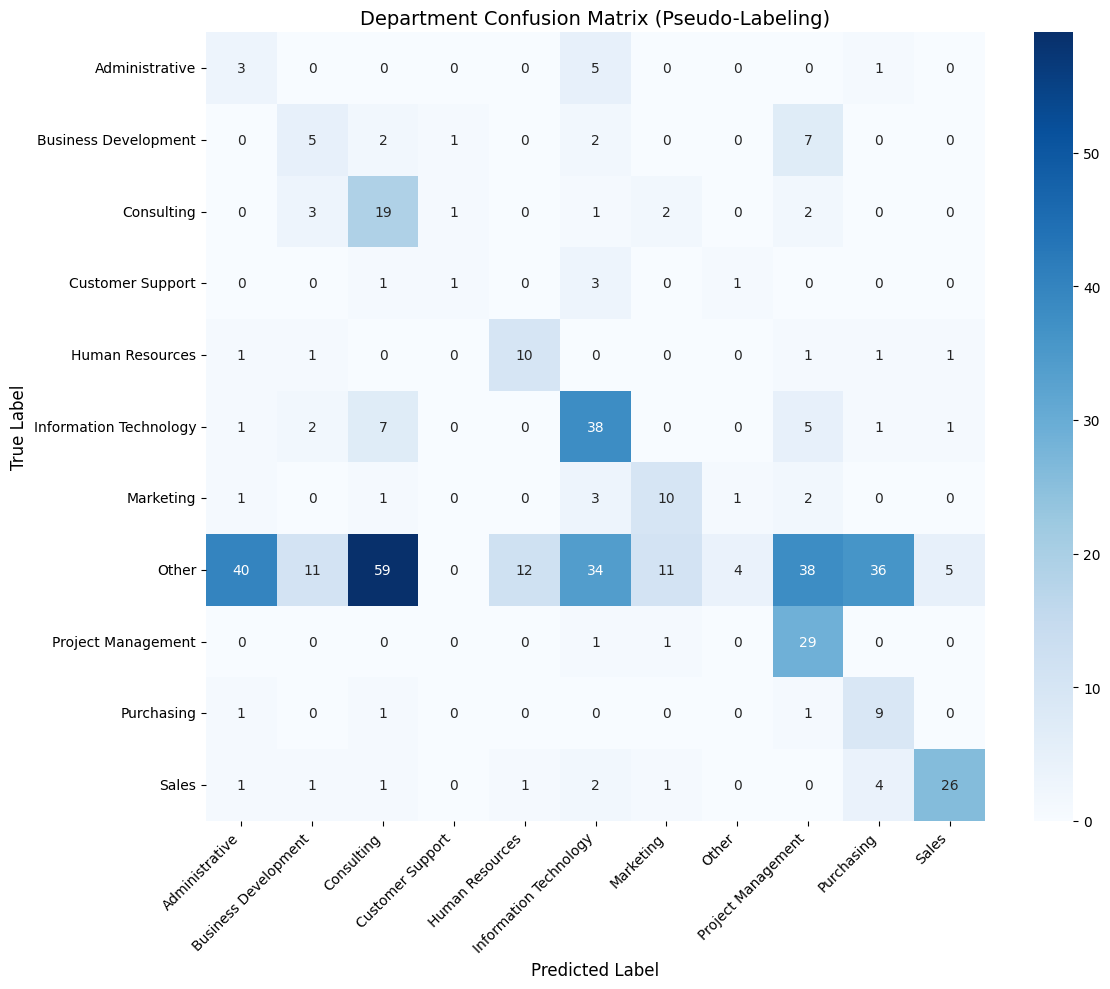

In [20]:
# Department confusion matrix
dept_cm = confusion_matrix(dept_true, dept_predictions)
dept_labels = sorted(set(dept_true + dept_predictions))

plt.figure(figsize=(12, 10))
sns.heatmap(dept_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dept_labels, yticklabels=dept_labels)
plt.title('Department Confusion Matrix (Pseudo-Labeling)', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

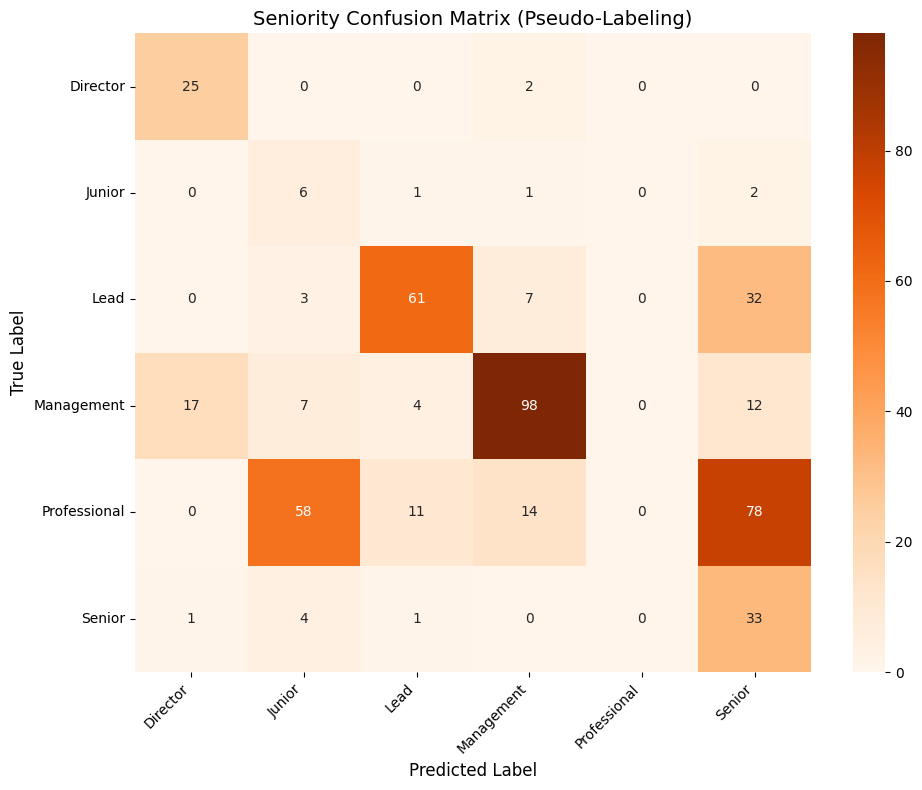

In [21]:
# Seniority confusion matrix
sen_cm = confusion_matrix(sen_true, sen_predictions)
sen_labels = sorted(set(sen_true + sen_predictions))

plt.figure(figsize=(10, 8))
sns.heatmap(sen_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sen_labels, yticklabels=sen_labels)
plt.title('Seniority Confusion Matrix (Pseudo-Labeling)', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 12. Save Results for Comparison

In [22]:
# Prepare results dictionary
results = {
    "approach": "Pseudo-Labeling + Transformer",
    "department": {
        "accuracy": float(dept_accuracy),
        "precision": float(dept_precision),
        "recall": float(dept_recall),
        "f1_macro": float(dept_f1),
        "f1_weighted": float(dept_weighted_f1),
        "per_class_f1": {k: float(v) for k, v in dept_f1_scores.items()}
    },
    "seniority": {
        "accuracy": float(sen_accuracy),
        "precision": float(sen_precision),
        "recall": float(sen_recall),
        "f1_macro": float(sen_f1),
        "f1_weighted": float(sen_weighted_f1),
        "per_class_f1": {k: float(v) for k, v in sen_f1_scores.items()}
    },
    "metadata": {
        "base_model": "distilbert-base-multilingual-cased",
        "pseudo_labeling_method": "embedding_classifier",
        "confidence_threshold": CONFIDENCE_THRESHOLD,
        "gold_samples": {"dept": len(dept_gold_df), "sen": len(sen_gold_df)},
        "silver_samples": {"dept": len(dept_silver_df), "sen": len(sen_silver_df)},
        "total_train_samples": len(dept_train_texts) + len(sen_train_texts),
        "epochs": 3,
        "batch_size": 16,
        "learning_rate": 2e-5
    },
    "timestamp": datetime.now().isoformat()
}

# Save to JSON
output_path = RESULTS_DIR / 'pseudo_labeling_results.json'
with open(output_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Results saved to: {output_path}")
print(f"\nSummary:")
print(f"  Department - Accuracy: {dept_accuracy:.4f}, F1 (macro): {dept_f1:.4f}")
print(f"  Seniority  - Accuracy: {sen_accuracy:.4f}, F1 (macro): {sen_f1:.4f}")


✅ Results saved to: results\pseudo_labeling_results.json

Summary:
  Department - Accuracy: 0.3222, F1 (macro): 0.3610
  Seniority  - Accuracy: 0.4665, F1 (macro): 0.4359


---

## Summary

### Hypothesis
Adding pseudo-labeled LinkedIn CV data should improve performance by:
- Providing domain adaptation (LinkedIn-specific patterns)
- Expanding training set size
- Exposing model to real-world title variations

### Results Comparison
Compare this with notebook 04 (transformer on lookup tables only):
- **Expected**: Slight improvement if pseudo-labels are high quality
- **Risk**: Performance drop if pseudo-labels are noisy

### Key Factors
- Confidence threshold (0.85) determines quality vs quantity tradeoff
- Embedding classifier quality affects pseudo-label accuracy
- Training longer might help model distinguish gold from silver

### Next Steps
- **Notebook 99**: Final comparison of ALL approaches